- Scenario:
Air-quality departments want to categorize cities into different pollution severity groups for better resource allocation.

- Objective: 
A model to segment cities into meaningful pollution categories (Low, Moderate, High, Critical) based on PM10, PM2.5, NO₂, PCA-based pollution index, and pollution-per-person.

In [12]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import joblib

In [13]:
df = pd.read_csv(r"C:\Desktop\predictiveAnalysis\data\processed\processed_data.csv")

In [14]:
df.head()

,who_region,iso3,country_name,city,year,pm10_concentration,pm25_concentration,no2_concentration,pm10_tempcov,pm25_tempcov,...,type_of_stations,population,latitude,longitude,who_ms,pollution_index,pollution_per_person,pollution_index_yearly_change,country_name_raw,city_raw
0,0.0,0.0,Spain,A Coruna,2013,-0.170206,-0.354191,0.504059,-0.317035,-2.475293,...,9,0.649804,43.367900,-8.418571,1,-0.095652,-0.041423,0.000000,Spain,A Coruna
1,0.0,0.0,Spain,A Coruna,2014,-0.002639,-0.023508,0.067105,0.260630,-0.169461,...,9,0.663666,43.368033,-8.418233,1,0.008241,-0.042623,2.702171,Spain,A Coruna
2,0.0,0.0,Spain,A Coruna,2015,-0.080175,-0.164766,0.215932,0.389000,-1.102774,...,9,0.663666,43.370375,-8.422900,1,-0.049060,-0.042222,-1.490347,Spain,A Coruna
3,0.0,0.0,Spain,A Coruna,2016,-0.177362,-0.228385,0.096767,0.389000,0.379546,...,9,0.663666,43.370375,-8.422900,1,-0.168826,-0.042543,-3.115034,Spain,A Coruna
4,0.0,0.0,Spain,A Coruna,2017,-0.027430,-0.156475,0.159910,0.324815,0.324645,...,9,0.663666,43.370375,-8.422900,1,-0.010575,-0.042373,4.116002,Spain,A Coruna


In [15]:
features = ["pm10_concentration", "pm25_concentration", "no2_concentration","pollution_per_person"]

X = df[features]

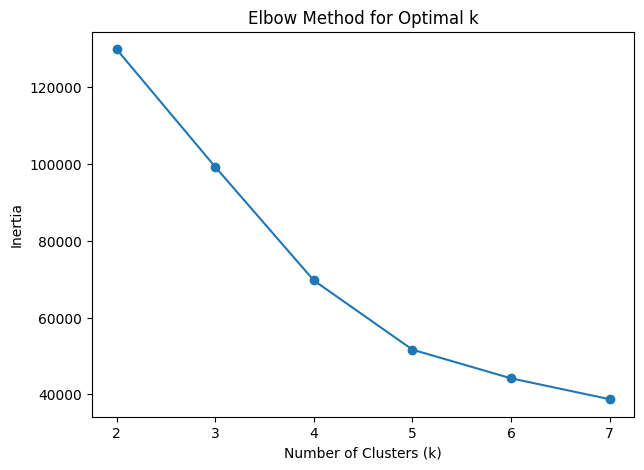

In [16]:
inertias = []
k_range = range(2, 8)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()


In [17]:
clusters = km.fit_predict(X)

# Assign clusters to DataFrame
df["pollution_cluster"] = clusters

In [18]:
sil_score = silhouette_score(X, df["pollution_cluster"])
print("Silhouette Score: ", sil_score)


Silhouette Score:  0.39358920194947644


In [19]:
cluster_order = (
    df.groupby("pollution_cluster")["pollution_index"]
      .mean()
      .sort_values()
      .index.tolist()
)

severity_labels = ["Low", "Moderate", "High", "Critical"]

label_map = {}

for i, cluster_id in enumerate(cluster_order):
    label_map[int(cluster_id)] = severity_labels[min(i, len(severity_labels) - 1)]

df["pollution_severity"] = df["pollution_cluster"].map(label_map)


- Visualization of Clusters according to Severity

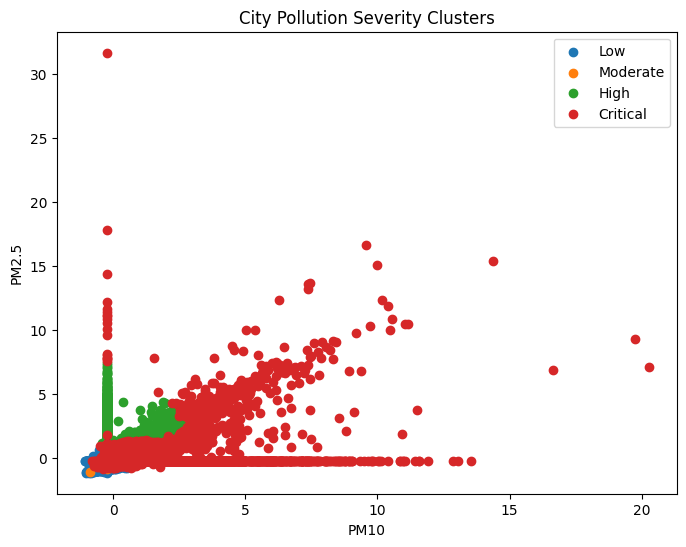

In [20]:
plt.figure(figsize=(8,6))
for severity in severity_labels:
    subset = df[df["pollution_severity"]==severity]
    plt.scatter(subset["pm10_concentration"], subset["pm25_concentration"], label=severity)
plt.xlabel("PM10")
plt.ylabel("PM2.5")
plt.title("City Pollution Severity Clusters")
plt.legend()                                 
plt.show()

In [21]:
joblib.dump(km, "../models/city_pollution_model.pkl")
joblib.dump(label_map, "../models/severity_label_map.pkl")

['../models/severity_label_map.pkl']

In [22]:
df.to_csv("../data/processed/processed_data.csv", index=False)